In [8]:
## Plotting Savgol smoothed, first, second and extrema using the second (newest) time step iteration where tstep = StepProcessTime (or ElapsedProcessTime, depending on the tool)
## Using 22 STI, step 6, wavelength C516
import pandas as pd
import glob
import os
import numpy as np
import dask.dataframe as dd
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,savgol_filter
from scipy import interpolate, stats
import seaborn as sns
from tqdm import tqdm                       # For progress bar, yay!


In [9]:
# Retrieving Metro Data from .txt files
mfile = []
metro = {}
metro_cols = ['waferscribe','ext_mv']
print('Reading Metro Data')
for filename in glob.glob("metro/22*"): # GH v 22 for STII
    metro[filename[6:-4]] = pd.read_csv(filename,usecols=metro_cols)[metro_cols] # Using filenames w/out path and file type as dictionary keys
    mfile.append(filename[6:-4])  # Create index of filename strings
    print(f'\t{filename} Data Finished')
    met = pd.concat(metro.values(),ignore_index=True)

# Trim down 'met' to relevant ext_mv values
paramVal = met['ext_mv']
paramBool = met[paramVal%1==0]
dropParam = paramBool.index
met.drop(dropParam, inplace=True)
MetroWafers = met.waferscribe


Reading Metro Data
	metro\22STIINT.txt Data Finished


In [10]:
# Retrieving OES Data from the .csv files, takes MUCH longer, retrieving specfic columns helps
ofile = []
oes = {}
data = {}
oes_cols = ['WAFER_SCRIBE','StepProcessTime','StepID', 'OES_CO483', 'OES_C516', 'OES_CN387'] # For STI INTEGRATED 
#oes_cols = ['LOT_ID','WAFER_SCRIBE','StepProcessTime','StepID', 'OES_BCl272', 'OES_C516', 'OES_CN387', 'OES_CO483', 'OES_F703', 'OES_H656', 'OES_O777', 'OES_OH309','OES_Si251','OES_Si288'] # For STI INTEGRATED
#oes_cols = ['WAFER_SCRIBE','ProcessElapsedTime','StepID', 'OESIB1', 'OESIB2', 'OESIB3', 'OESIB4', 'OESIB5', 'OESIB6', 'OESIB7', 'OESIB8'] # For GH CONTACT 
print('Reading OES Data')
for filename in glob.glob("oes/5030-22 STI INTEGRATED DRY ETCH_*.csv"): #5030-22 STI INTEGRATED DRY ETCH_1 #3500-GH CONTACT OXIDE DRY ETCH_10.csv
    oes[filename[4:-4]] = pd.read_csv(filename, usecols=oes_cols)[oes_cols] # ,parse_dates=['RunStartTime', 'TimeStamp'],infer_datetime_format=True
    ofile.append(filename[4:-4]) # Create index of filename strings
    data = pd.concat(oes.values(),ignore_index=True) # Struggles with STI INTEGRATED data # pd.concat(oes.values(),ignore_index=True)
    print(f'\t{filename} Data Finished')

# Trim down 'data' to only metro-matching wafers by removing them
UniqueWafers = data.WAFER_SCRIBE.unique()
nonWafers = np.isin(UniqueWafers,list(MetroWafers),invert=True)
i = np.where(nonWafers)[0]
WaferScribe = []
WaferScribe = (UniqueWafers[i])


Reading OES Data
	oes\5030-22 STI INTEGRATED DRY ETCH_2.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_3.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_4.csv Data Finished


In [11]:
print('Trimming Down Data to Only Metro-Matching Wafers')
indexNames = []
for x in tqdm(WaferScribe):
    WaferScribeData = data['WAFER_SCRIBE']
    dataindex = data[WaferScribeData == x]
    indexNames = dataindex.index
    data.drop(indexNames , inplace=True)
print('\tDone!') 
UniqueWafers = data.WAFER_SCRIBE.unique()


  0%|                                                                                          | 0/575 [00:00<?, ?it/s]

Trimming Down Data to Only Metro-Matching Wafers


100%|████████████████████████████████████████████████████████████████████████████████| 575/575 [02:26<00:00,  3.93it/s]

	Done!


In [13]:
# Turning Data into Wafer for easy keys and converting dates into 
t_sec = {}
Wafer = {}
DataFrameDict = {elem : pd.DataFrame for elem in UniqueWafers}
print('Creating Wafer Data Set & Processing Dates into Time in Seconds')
for i,key in enumerate(tqdm(DataFrameDict.keys())):
    Wafer[i] = pd.DataFrame.from_dict(data[:][data.WAFER_SCRIBE == key]) # Create DataFrame for specific wafers
    StepTime = [col for col in Wafer[i].columns if 'Process' in col] #Create list of all intensity columns w/rt element
    t_sec[i] = Wafer[i][StepTime].dropna() 
print('\tDone!')
OES_col = [col for col in Wafer[i].columns if 'OES' in col] #Create list of all intensity columns w/rt element
step = 6
wafer_param_time = met[['waferscribe','ext_mv']]
etch_time = []
peakTime = []
waferScribe = []


 14%|███████████▌                                                                       | 7/50 [00:00<00:00, 63.63it/s]

Creating Wafer Data Set & Processing Dates into Time in Seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.58it/s]

	Done!


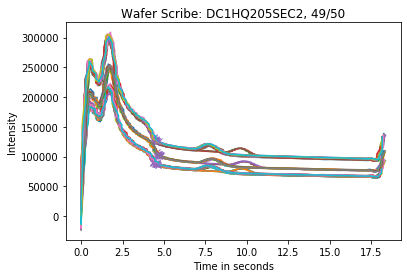

In [37]:

# Only temporarily kept in here
for x in range (len(UniqueWafers)): #len(UniqueWafers)): #5): #
    #fig = plt.figure()
    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==step]
    x_int = np.linspace(Tsteps.iloc[0], Tsteps.iloc[-1], 100)
    #plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25) #, ymin=0, ymax=1, **kwargs)
    plt.title(f"Wafer Scribe: {UniqueWafers[x]}, {x}/{len(UniqueWafers)}")
    for y in range(1,2): #len(OES_col)): #
        WinLen = 15
        POrder = 5
        Intensity = Wafer[x][OES_col[y]].loc[Wafer[x]['StepID']==step]
        if Tsteps.values[-1] == 0.:                                 # Is the final time step zero for some weird reason? 
            Tsteps.drop(Tsteps.tail(1).index,inplace=True)          # Let's get rid of it then, it's messing up our data
            Intensity.drop(Intensity.tail(1).index,inplace=True)    # Keep consistent for plotting purposes
        #plt.plot(Tsteps,Intensity, label=f"{OES_col[y]}") #,color="tab:orange")                    # OG Data
        SGsmooth = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 0)  #
        plt.plot(Tsteps,SGsmooth, label=f"{UniqueWafers[x]}")#,color="tab:blue")                      # Smoothed Data     f"Smooth {OES_col[y]}"
        first = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 1)
        #plt.plot(Tsteps,first, label=f"1st {OES_col[y]}",linestyle = '--',color="tab:red")          # First Derivative Plot
        second = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 2)
        #plt.plot(Tsteps,second, label=f"2nd {OES_col[y]}",linestyle = ':',color="tab:green")        # Second Derivative Plot
        
        peaks, _ = find_peaks(second, height=5e2) #, distance=150)
        peaks = peaks[np.concatenate(Tsteps.values[peaks], axis=None)>4]
        peaks = peaks[np.concatenate(Tsteps.values[peaks], axis=None)<8]
        peaks = peaks[0]
        #plt.plot(Tsteps[peaks], first[peaks], "x",color="tab:purple", label = "Peaks")              # First Derivative Peaks
        #plt.plot(Tsteps[peaks], second[peaks], "x",color="tab:purple", label = "Peaks")             # Second Derivative Peaks
        plt.plot(Tsteps.values[peaks], SGsmooth[peaks], "x",color="tab:purple") #, label = "Peaks")              # Smoothed Peaks
        
#       print(f"\tWafer Scribe: {UniqueWafers[x]}, {x}/{len(UniqueWafers)}")
#       print("Tsteps.values[peaks]:\t",Tsteps.values[peaks])
#       print("Intensity.values[peaks]:\t",Intensity.values[peaks])
#       print("np.concatenate(Tsteps.values[peaks[0]], axis=None)-np.concatenate(Tsteps.values[0], axis=None):\t",np.concatenate(Tsteps.values[peaks[0]], axis=None)-np.concatenate(Tsteps.values[0], axis=None))

        #print(x,len(peaks))
        #plt.xlim(4.2,5)
        #plt.ylim(8e4,15e4)
        #waferScrbe.append(UniqueWafers[x])
        try:
            peakTime.append(np.concatenate(Tsteps.values[peaks[0]], axis=None)) # -np.concatenate(Tsteps.values[0], axis=None) # try/except -- taking in the first value within x-int[peaks]: x_int[-1]-x_int[peaks[0]]
            waferScribe.append(UniqueWafers[x])
        except IndexError:
            pass
        
    plt.ylabel("Intensity")
    plt.xlabel("Time in seconds")
    #plt.legend()
plt.show()

R-squared: 0.010467453726208362


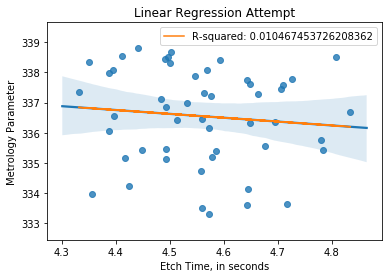

In [15]:
etch_time = pd.DataFrame({'waferscribe':waferScribe,'peaks':peakTime})
#etch_time.drop(etch_time.loc[etch_time['peaks'] < 1,'peaks'].index, inplace=True)      # Is this doing anything? I don't think so...
#etch_time.drop(etch_time.loc[etch_time['peaks'] > 30,'peaks'].index, inplace=True)

#print('Etch',(etch_time))
#print('Param',(wafer_param_time))
result = pd.merge(etch_time, wafer_param_time, on = ['waferscribe'])
slope, intercept, r_value, p_value, std_err = stats.linregress(x=result.peaks.astype('float'), y=result.ext_mv)
print(f"R-squared: {r_value**2}")
fig = plt.figure()
sns.regplot(x=result.peaks.astype('float'), y=result.ext_mv)
#plt.scatter(result.peaks, result.ext_mv)
plt.plot(result.peaks, result.peaks*slope+intercept, label = f"R-squared: {r_value**2}")
plt.title("Linear Regression Attempt")
plt.ylabel("Metrology Parameter")
plt.xlabel("Etch Time, in seconds")
plt.legend()
plt.show()